In [ ]:
pip install japanize-matplotlib

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor

In [6]:
# NOTE: モデルのsample_weightを確認するために作成したモデル
class DummyRegressor:
    def __init__(self):
        self.model = DecisionTreeRegressor(max_depth=5)
        self.error_vector = None
        self.X_for_plot = None
        self.y_for_plot = None

    def fit(self, X, y):
        self.model.fit(X, y)
        y_pred = self.model.predict(X)

        # 重みは回帰の誤差を元に計算する
        # https://github.com/scikit-learn/scikit-learn/blob/main/sklearn/ensemble/_weight_boosting.py#L1130
        self.error_vector = np.abs(y_pred - y)
        self.X_for_plot = X.copy()
        self.y_for_plot = y.copy()
        return self.model

    def predict(self, X, check_input=True):
        return self.model.predict(X)

    def get_params(self, deep=False):
        return {}

    def set_params(self, deep=False):
        return {}


訓練データに回帰モデルを当てはめる

---



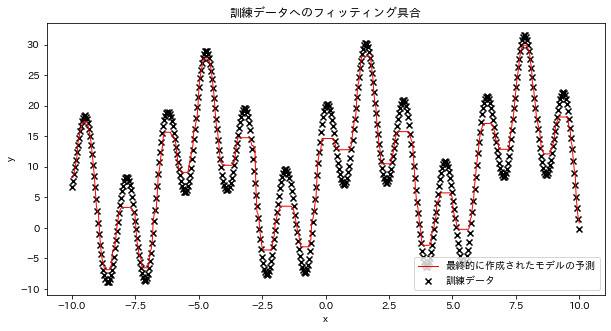

In [7]:
# 訓練データ
X = np.linspace(-10, 10, 500)[:, np.newaxis]
y = (np.sin(X).ravel() + np.cos(4 * X).ravel()) * 10 + 10 + np.linspace(-2, 2, 500)

## 回帰モデルを作成
reg = AdaBoostRegressor(
    DummyRegressor(),
    n_estimators=100,
    random_state=100,
    loss="linear",
    learning_rate=0.8,
)
reg.fit(X, y)
y_pred = reg.predict(X)

# 訓練データへのフィッティング具合を確認する
plt.figure(figsize=(10, 5))
plt.scatter(X, y, c="k", marker="x", label="訓練データ")
plt.plot(X, y_pred, c="r", label="最終的に作成されたモデルの予測", linewidth=1)
plt.xlabel("x")
plt.ylabel("y")
plt.title("訓練データへのフィッティング具合")
plt.legend()
plt.show()


標本の重みを可視化(loss=’linear’の場合)
Adaboostでは回帰の誤差を元い重みを決定する。’linear’ に指定した時の重みの大きさを可視化します。 重みが追加されたデータは訓練時にサンプルされる確率が高くなる様子を確認します。

---



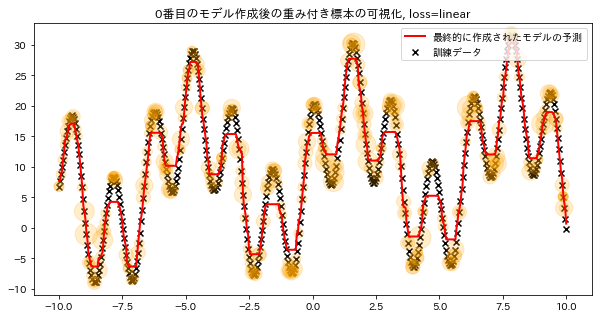

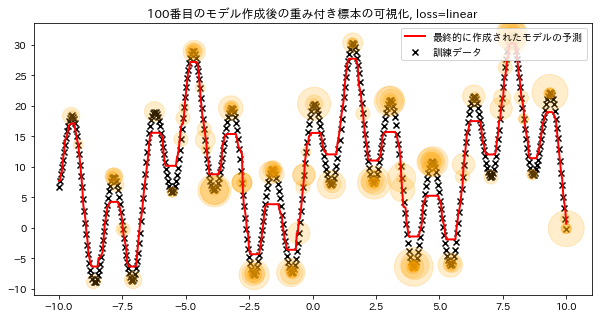

In [8]:
def visualize_weight(reg, X, y, y_pred):
    """標本の重みに相当する値(サンプリングされた数)をプロットするための関数

    Parameters
    ----------
    reg : sklearn.ensemble._weight_boosting
        ブースティングモデル
    X : numpy.ndarray
        訓練データ
    y : numpy.ndarray
        教師データ
    y_pred:
        モデルの予測値
    """
    assert reg.estimators_ is not None, "len(reg.estimators_) > 0"

    for i, estimators_i in enumerate(reg.estimators_):
        if i % 100 == 0:
            # i番目のモデル作成に使用したデータに、データが何回出現するかをカウント
            weight_dict = {xi: 0 for xi in X.ravel()}
            for xi in estimators_i.X_for_plot.ravel():
                weight_dict[xi] += 1

            # 出現回数をグラフにオレンジ円でプロットする(多いほど大きい円)
            weight_x_sorted = sorted(weight_dict.items(), key=lambda x: x[0])
            weight_vec = np.array([s * 100 for xi, s in weight_x_sorted])

            # グラフをプロット
            plt.figure(figsize=(10, 5))
            plt.title(f"{i}番目のモデル作成後の重み付き標本の可視化, loss={reg.loss}")
            plt.scatter(X, y, c="k", marker="x", label="訓練データ")
            plt.scatter(
                estimators_i.X_for_plot,
                estimators_i.y_for_plot,
                marker="o",
                alpha=0.2,
                c="orange",
                s=weight_vec,
            )
            plt.plot(X, y_pred, c="r", label="最終的に作成されたモデルの予測", linewidth=2)
            plt.legend(loc="upper right")
            plt.show()


## loss="linear"で回帰モデルを作成
reg = AdaBoostRegressor(
    DummyRegressor(),
    n_estimators=101,
    random_state=100,
    loss="linear",
    learning_rate=1,
)
reg.fit(X, y)
y_pred = reg.predict(X)
visualize_weight(reg, X, y, y_pred)